# Reproducing Results from the Paper
This notebook will show the results from the paper after running all the experiments. The required files should be saved in the corresponding directories.

## Table of Contents <a class="anchor" id="bullet0"></a>

### Simulated Dataset

* [Performance on simulated datasets](#bullet1)
* [WinIT performance on Delayed Spike for different window sizes](#bullet2)
* [Saliency map](#bullet3)

### Real World Datasets 

* [Load the results for MIMIC-III experiments](#bullet4)
* [Performance on MIMIC using END masking](#bullet5)
* [AUC Drop performance on MIMIC-III mortality using different metrics in WinIT for STD masking](#bullet6)
* [Counts of masked observations for IG, FIT, Dynamask and WinIT at each time step in the MIMIC-III K=50 performance drop experiment](#bullet7)
* [Performance on MIMIC for different window sizes](#bullet8)
* [Saliency map](#bullet9)
* [Precision-Recall Curve for Dynamask](#bullet10)
* [AUC Drop, Mean Prediction Changes and number of masked observations for STD-BAL, STD and END masking method for different explainability methods on K=50](#bullet11)
  * [1-Layer GRU](#bullet12)
  * [ConvNet](#bullet13)
  * [LSTM](#bullet14)
  * [3-Layer GRU](#bullet15)

Import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import pickle as pkl

In [2]:
pd.options.display.float_format = '{:.3f}'.format

A convenient function to simplify the explainer string, especially for dynamask.

In [ ]:
def simplify_explainer_str(x):
    explainer_name = x.split("_")[0]
    if explainer_name not in ["winit", "jimex"]:
        return explainer_name
    return x

### Performance on the simulated datasets. <a class="anchor" id="bullet1"></a> $\quad$ [TOP](#bullet0) 


#### New code

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# --------- CONFIG ---------
DATASET_NAME = "simulated_switch"
DATA_DIR = "/home/users/nus/e1333861/graph-winit/output/gru1layer/" + DATASET_NAME
PATTERN = os.path.join(DATA_DIR, "results*.csv")
OUT_DIR = os.path.join(DATA_DIR, "tables")
os.makedirs(OUT_DIR, exist_ok=True)

# Metrics to summarize as mean ± std (edit order to taste)
METRICS = [
    ("AUROC",      "AUROC"),
    ("AUPRC",      "AUPRC"),
    ("AUP",        "AUP"),
    ("AUR",        "AUR"),
    ("Mean rank",  "Mean Rank"),
    ("Mean rank (min)",  "Mean Rank (min)"),
    ("AP",        "AP"),
    ("Pos ratio",  "Pos Ratio"),
]
# --------------------------

# Load
paths = sorted(glob.glob(PATTERN))
if not paths:
    raise FileNotFoundError(f"No files found at {PATTERN}")

dfs = []
for p in paths:
    try:
        df = pd.read_csv(p)
        dfs.append(df)
    except Exception as e:
        print(f"[WARN] Skipping {p}: {e}")
if not dfs:
    raise RuntimeError("No readable CSVs")

df = pd.concat(dfs, ignore_index=True)

# Keep only needed columns; gracefully drop missing
needed_cols = {"dataset", "explainer"} | {c for c, _ in METRICS}
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required column(s): {missing}")

df = df[list(needed_cols)].copy()

# Coerce to numeric where relevant
for c, _ in METRICS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Add explainer family
df["explainer_family"] = df["explainer"].astype(str).str.split("_").str[0]

# Group & aggregate (mean, std, n per metric)
group_cols = ["dataset", "explainer", "explainer_family"]
agg_dict = {c: ["mean", "std", "count"] for c, _ in METRICS}
g = df.groupby(group_cols).agg(agg_dict)

# Flatten MultiIndex columns: "AUROC_mean", "AUROC_std", ...
g.columns = [f"{metric}_{stat}" for metric, stat in g.columns]
g = g.reset_index()

# Format function mean±std (only if count>1; else just mean)
def fmt_mu_sigma(row, metric, digits=3):
    mu = row[f"{metric}_mean"]
    sd = row.get(f"{metric}_std", np.nan)
    n  = row.get(f"{metric}_count", 1)
    if pd.isna(mu):
        return "-"
    if n is not None and n > 1 and pd.notna(sd):
        return f"{mu:.{digits}f}±{sd:.{digits}f}"
    return f"{mu:.{digits}f}"

# Build per-dataset LaTeX tables
for dataset, df_ds in g.groupby("dataset", sort=False):
    # Sort: family then explainer (tweak to taste)
    df_ds = df_ds.sort_values(["explainer_family", "explainer"])

    # Compose a printable table with formatted columns
    display_cols = ["Method", "Family"] + [nice for _, nice in METRICS]
    rows = []
    for _, r in df_ds.iterrows():
        row = {
            "Method": r["explainer"],
            "Family": r["explainer_family"],
        }
        for metric, nice in METRICS:
            row[nice] = fmt_mu_sigma(r, metric)
        rows.append(row)

    table_df = pd.DataFrame(rows, columns=display_cols)
    display(table_df)
    

,Method,Family,AUROC,AUPRC,AUP,AUR,Mean Rank,Pos Ratio
0,deeplift,deeplift,0.500,0.028,0.028,0.500,149.121,8.025
1,dynamask_gaussian_timereg_1_sizereg_100_area_0...,dynamask,0.687,0.205,0.043,0.679,94.740,8.025
2,fo_sample_3,fo,0.574,0.029,0.029,0.572,127.405,8.025
3,gradientshap,gradientshap,0.497,0.027,0.027,0.498,149.697,8.025
4,ig,ig,0.500,0.028,0.028,0.500,149.135,8.025
5,jimex_num_masks_3_window_size_10_num_samples_3...,jimex,0.500,0.514,0.026,0.486,149.000,8.025
6,winit_window_10_pd_usedatadist,winit,0.546±0.000,0.032±0.000,0.031±0.000,0.545±0.000,135.969±0.000,8.025±0.000
7,winit_window_20_pd_usedatadist,winit,0.535±0.000,0.031±0.000,0.030±0.000,0.534±0.000,138.917±0.000,8.025±0.000
8,winit_window_30_pd_usedatadist,winit,0.529±0.000,0.030±0.000,0.029±0.000,0.528±0.000,140.866±0.000,8.025±0.000


#### Old code

### WinIT performance on Delayed Spike for different window sizes  <a class="anchor" id="bullet2"></a>$\quad$ [TOP](#bullet0) 

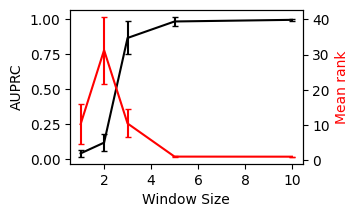

In [5]:
show_std = True
windows = [1,2,3,5,10]

dg = pd.read_csv(f"../output/gru1layer/simulated_spike_delay_2/results.csv")
explainers = [f"winit_window_{window}_pd" for window in windows]
to_show = ["mean", "std"] if show_std else ["mean"]
dg = (dg
      .drop(["cv", "Auroc", "Pos ratio", "Mean rank", "dataset", "Avpr"], axis=1)
      .groupby(by=["explainer"])
      .agg(to_show)
      .loc[explainers]
     )

plt.close()
fig, ax = plt.subplots(figsize=(3, 2))
ax.errorbar(windows, dg["Auprc"]["mean"], yerr=dg["Auprc"]["std"], capsize=2, color="black")
ax.set_ylabel("AUPRC")
ax.set_xlabel("Window Size")

ax2 = ax.twinx()
ax2.set_ylabel('Mean rank', color="red")
ax2.errorbar(windows, dg["Mean rank (min)"]["mean"], yerr=dg["Mean rank (min)"]["std"], capsize=2, color="red")
plt.show()

### Saliency maps <a class="anchor" id="bullet3"></a>$\quad$ [TOP](#bullet0) 

#### Spike

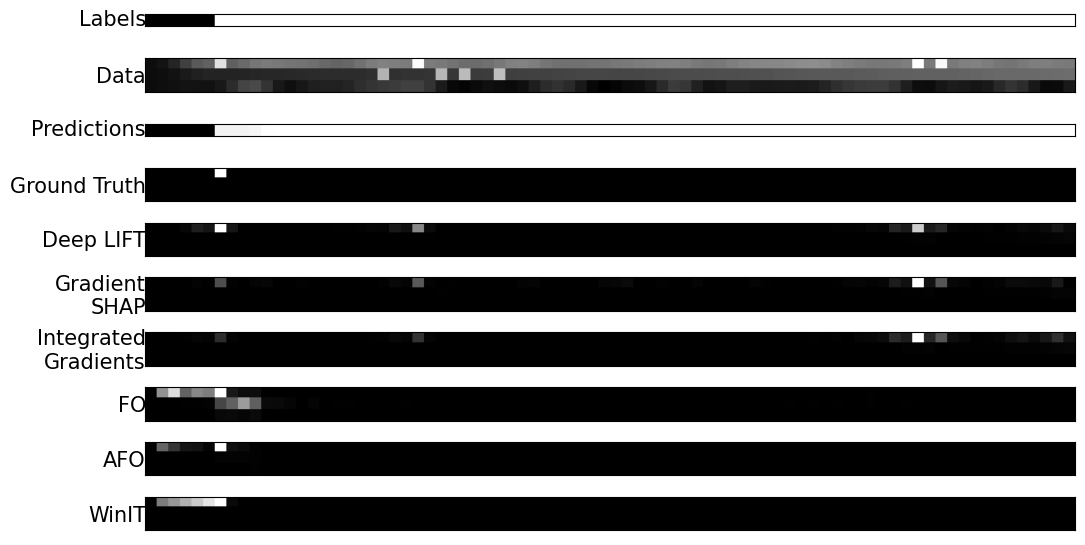

In [14]:
j = 1
# sim = "spike_delay_2"
sim = "spike"
# sim = "state"
# sim = "data_l2x"
cv = 4

extras = ['labels', 'data', f'preds_cv_{cv}', 'ground_truth_attributions']
extra_names = ['Labels', "Data", "Predictions", "Ground Truth"]
explainers = ["deeplift", 
              "gradientshap", 
              "ig",
              "fo", "afo", 
            #   "fit", 
              "winit_window_10_pd"]
explainer_names = ["Deep LIFT", 
                   "Gradient\nSHAP", 
                   "Integrated\nGradients", 
                   "FO", "AFO", 
                #    "FIT", 
                   "WinIT"]

plt.close()
fig, ax = plt.subplots(len(explainers)+len(extras), 1, figsize=(12, 7))

for i, (extra, extra_name) in enumerate(zip(extras, extra_names)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{extra}_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
        ax[i].text(0, 3 if extra in ['labels', f'preds_cv_{cv}'] else 12, extra_name, 
                   ha='right', fontsize=15, va="center")

for i, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names)):
    i = i + len(extras)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{explainer}_mean_cv_{cv}_attributions_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
    ax[i].text(0, 12, explainer_name, ha="right", fontsize=15, va="center")

plt.show()

#### State

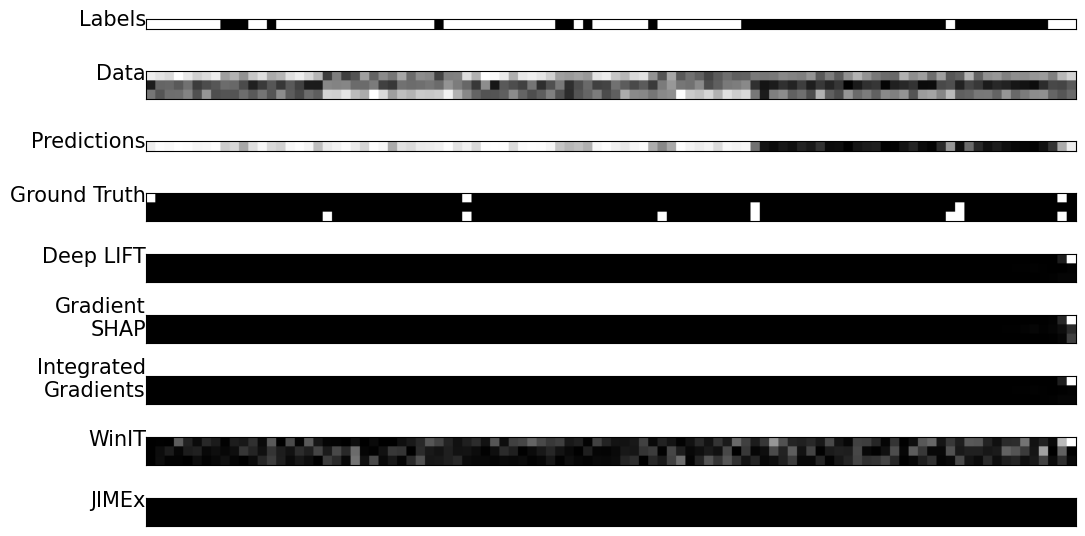

In [10]:
j = 0
# sim = "spike_delay_2"
# sim = "spike"
# sim = "state"
sim = "switch"
cv = 0

extras = ['labels', 'data', f'preds_cv_{cv}', 'ground_truth_attributions']
extra_names = ['Labels', "Data", "Predictions", "Ground Truth"]
explainers = ["deeplift", 
              "gradientshap", 
              "ig",
            #   "fo", "afo", 
            #   "fit", 
              "winit_window_10_pd_usedatadist",
            #   "biwinit_window_10_pd_usedatadist",
              "jimex_num_masks_3_window_size_10_num_samples_3_wt_bounds_1_4_pd_usedatadist"]

explainer_names = ["Deep LIFT", 
                   "Gradient\nSHAP", 
                   "Integrated\nGradients", 
                #    "FO", "AFO", 
                #    "FIT", 
                   "WinIT",
                   "JIMEx"]

plt.close()
fig, ax = plt.subplots(len(explainers)+len(extras), 1, figsize=(12, 7))

for i, (extra, extra_name) in enumerate(zip(extras, extra_names)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{extra}_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
        ax[i].text(0, 3 if extra in ['labels', f'preds_cv_{cv}'] else 12, extra_name, 
                   ha='right', fontsize=15, va="center")

for i, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names)):
    i = i + len(extras)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{explainer}_mean_cv_{cv}_attributions_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
    ax[i].text(0, 12, explainer_name, ha="right", fontsize=15, va="center")

plt.show()

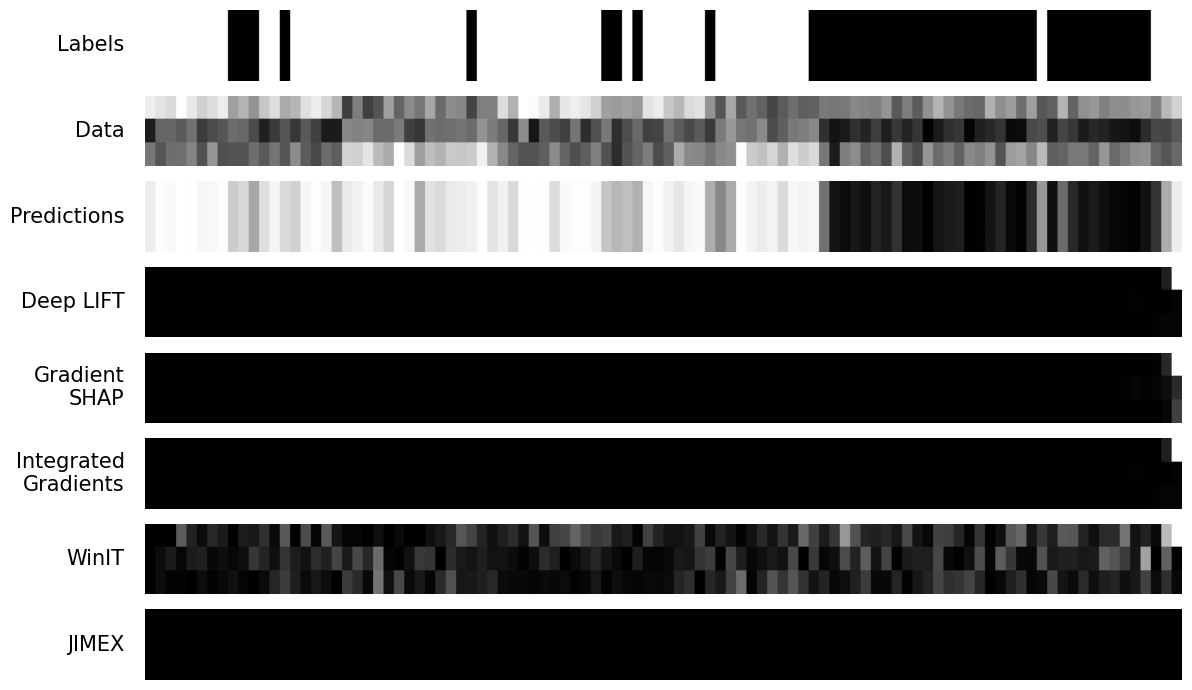

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

j = 0
sim = "simulated_switch"
cv = 0

extras = ['labels', 
          'data', 
          f'preds_cv_{cv}', 
          # 'ground_truth_attributions'
          ]
extra_names = ['Labels', 
               "Data",
                 "Predictions", 
                #  "Ground Truth"
                 ]
explainers = ["deeplift",
              "gradientshap",
              "ig",
            #   "fit",
              "winit_window_10_pd_usedatadist",
              "jimex_num_masks_3_window_size_10_num_samples_3_wt_bounds_1_4_pd_usedatadist"]
explainer_names = ["Deep LIFT",
                   "Gradient\nSHAP",
                   "Integrated\nGradients",
                #    "FIT",
                   "WinIT",
                   "JIMEX"]

fig, ax = plt.subplots(len(extras)+len(explainers), 1, figsize=(12, 7), sharex=True)

for i, (extra, extra_name) in enumerate(zip(extras, extra_names)):
    ax[i].axis('off')
    fn = f"../plots/gru1layer/{sim}/{extra}_{j}.png"
    img = Image.open(fn)
    # Plot with explicit extent [0,1] on x and y
    ax[i].imshow(img, aspect='auto', extent=[0,1,0,1])
    ax[i].text(-0.02, 0.5, extra_name, ha='right', va='center', fontsize=15)
    ax[i].set_xlim(0,1)
    ax[i].set_ylim(0,1)

for k, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names), start=len(extras)):
    ax[k].axis('off')
    fn = f"../plots/gru1layer/{sim}/{explainer}_mean_cv_{cv}_attributions_{j}.png"
    img = Image.open(fn)
    ax[k].imshow(img, aspect='auto', extent=[0,1,0,1])
    ax[k].text(-0.02, 0.5, explainer_name, ha='right', va='center', fontsize=15)
    ax[k].set_xlim(0,1)
    ax[k].set_ylim(0,1)

plt.tight_layout()
plt.show()


### Load the results for Real World Dataset experiments. <a class="anchor" id="bullet4"></a>$\quad$ [TOP](#bullet0) 

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_top__masker_cells_zero_mean.png


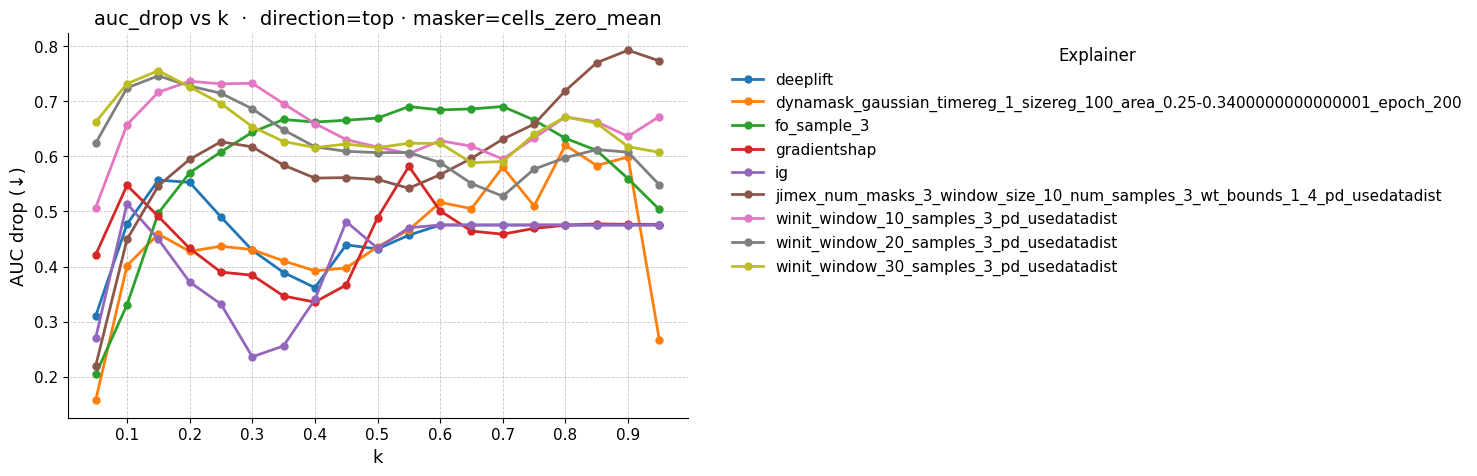

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_top__masker_cells_mean_mean.png


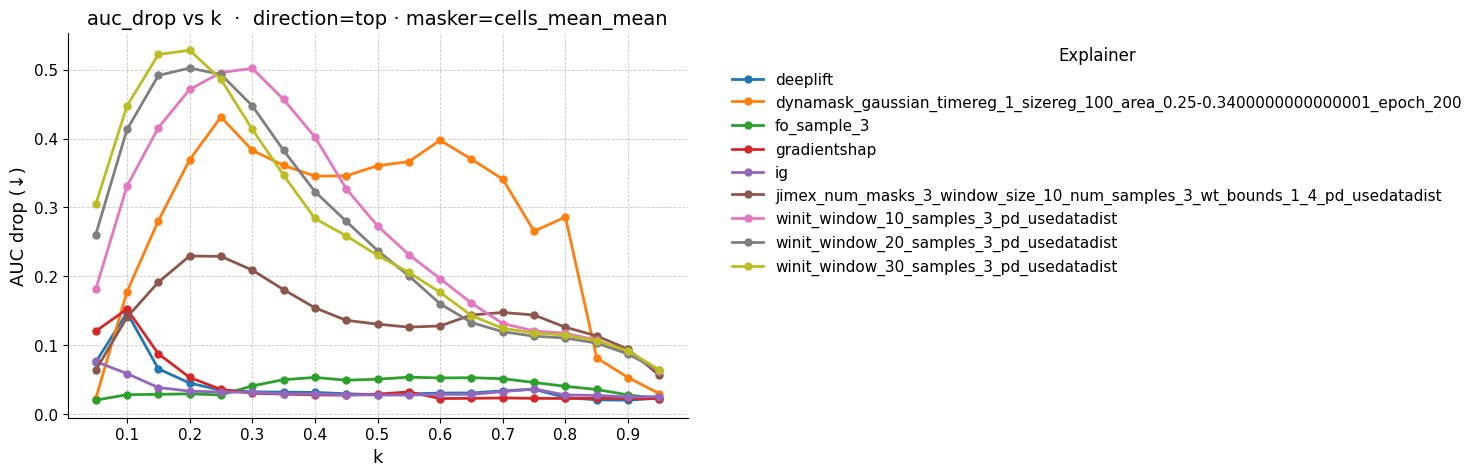

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_top__masker_nan.png


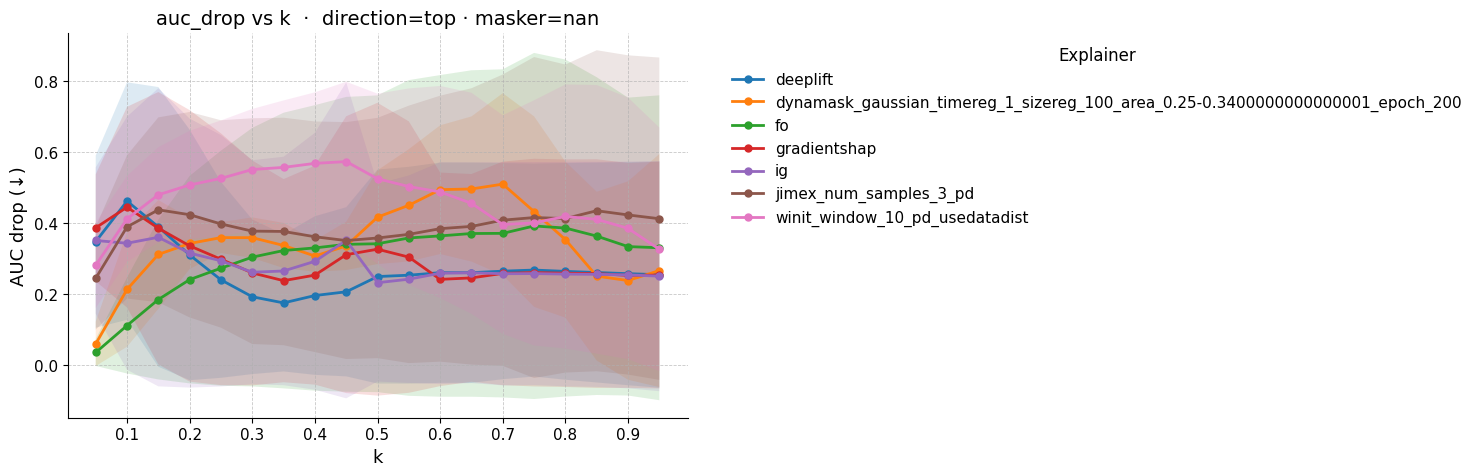

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_top__masker_cells_zero_mean.png


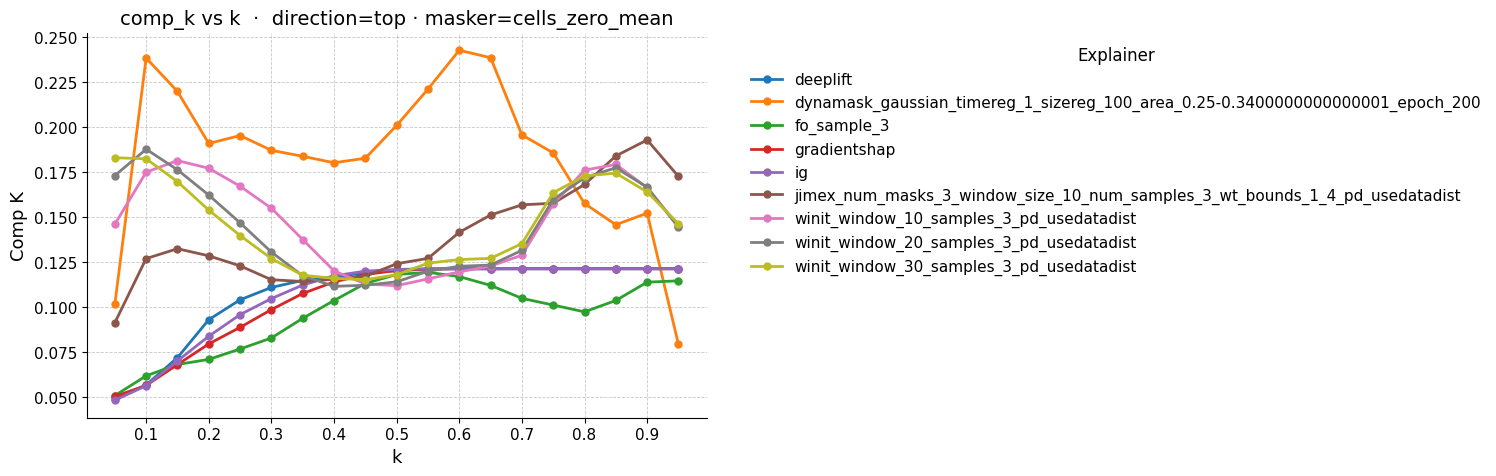

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_top__masker_cells_mean_mean.png


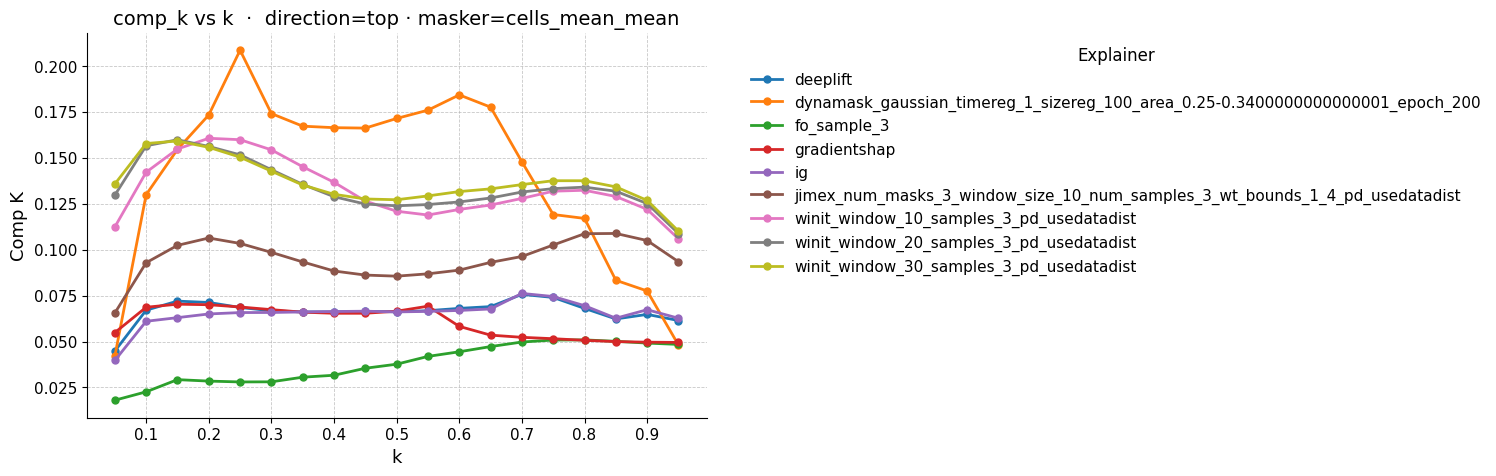

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_top__masker_nan.png


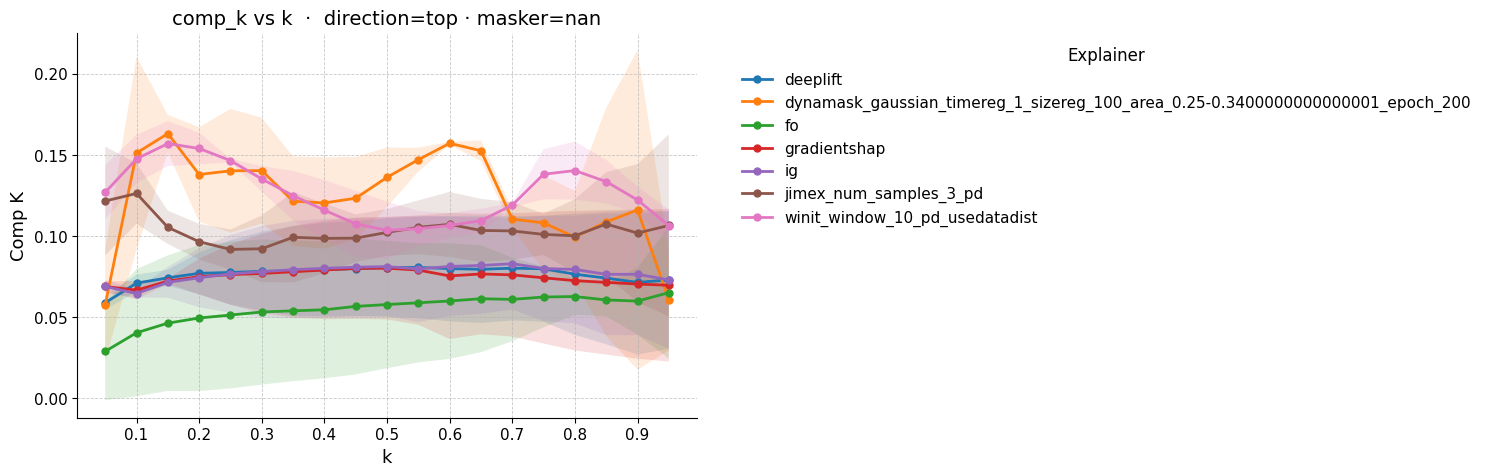

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_top__masker_cells_zero_mean.png


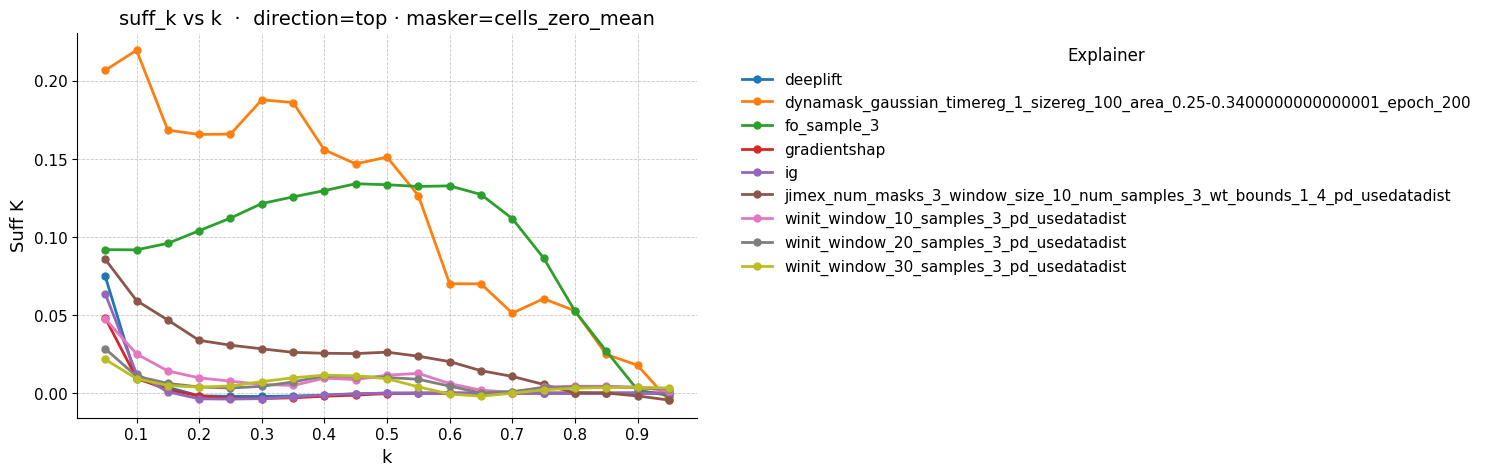

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_top__masker_cells_mean_mean.png


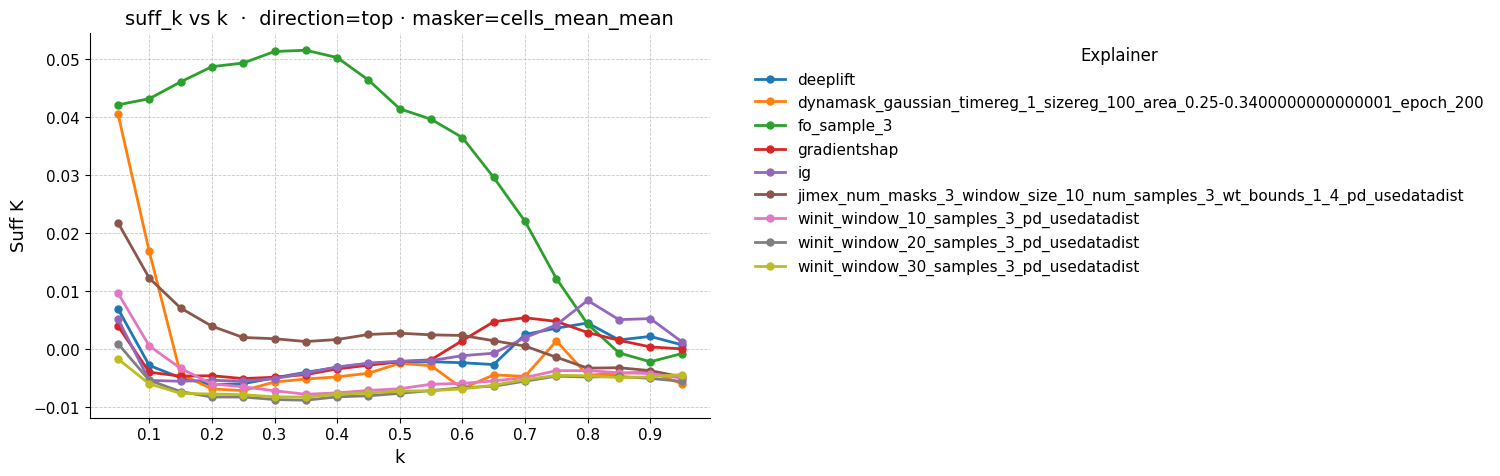

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_top__masker_nan.png


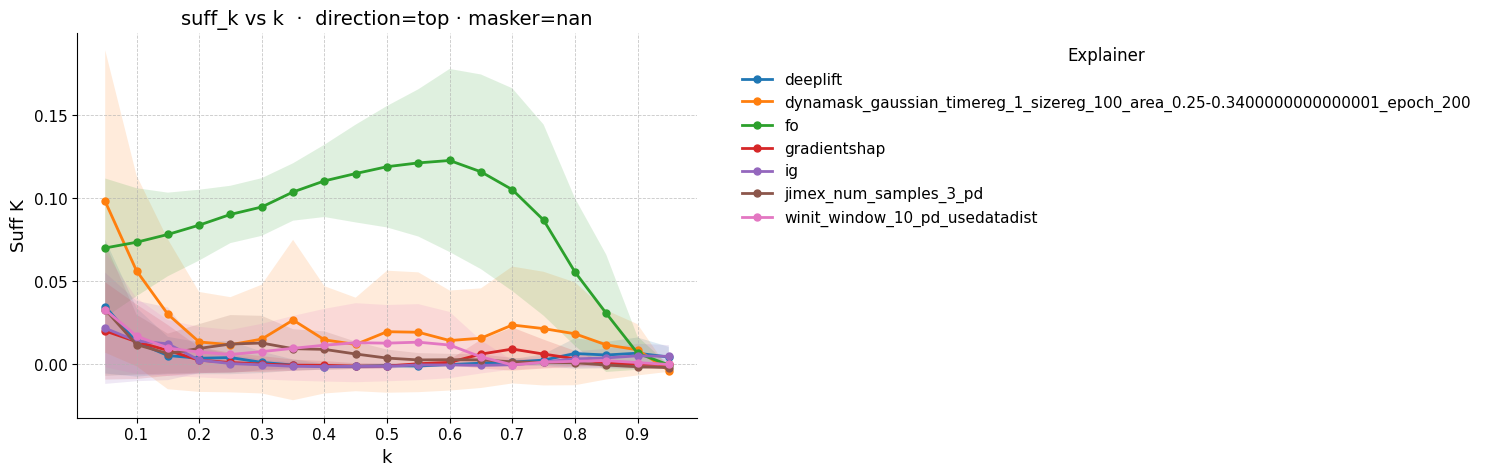

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_top__masker_cells_zero_mean.png


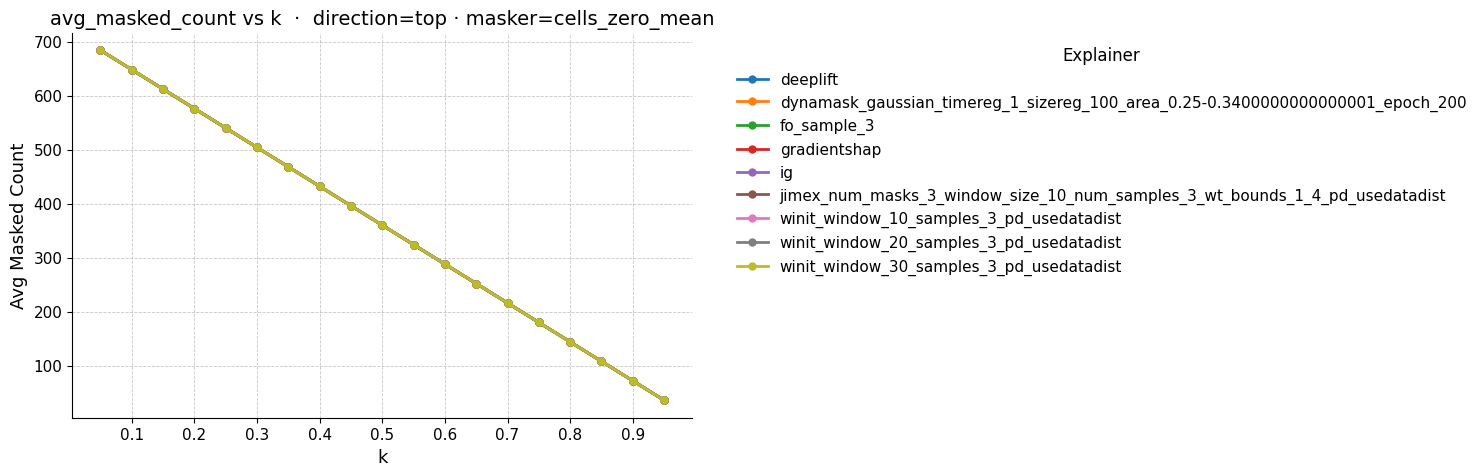

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_top__masker_cells_mean_mean.png


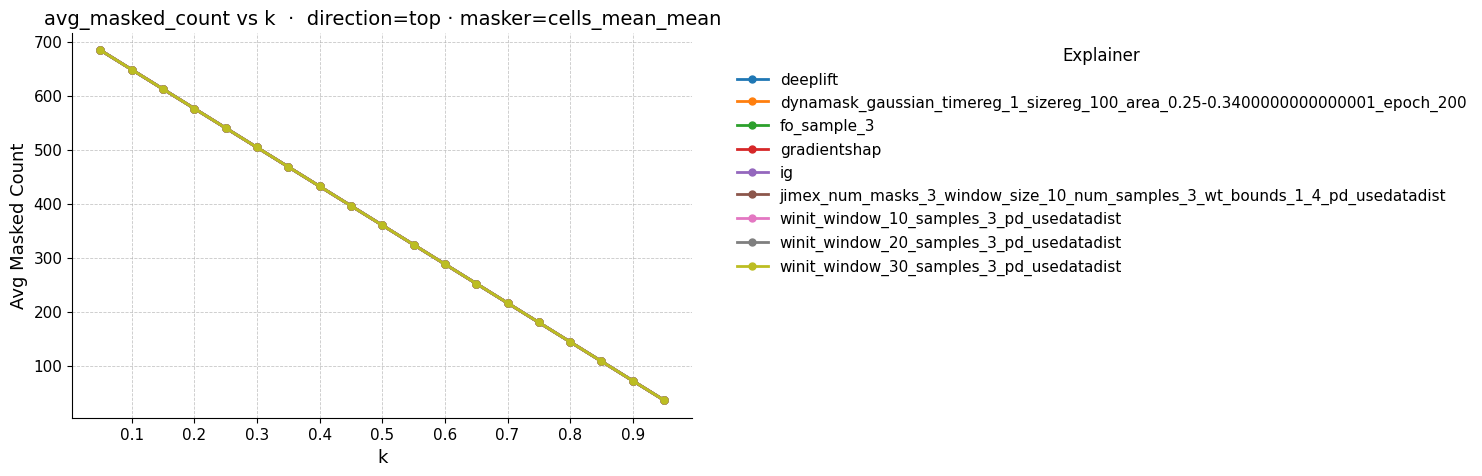

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_top__masker_nan.png


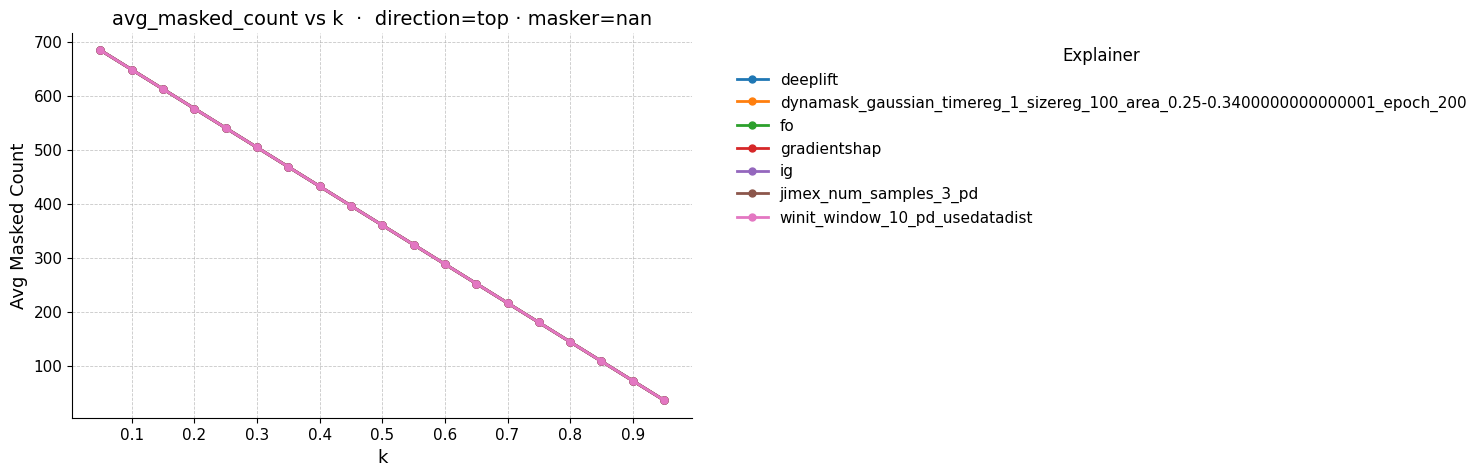

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_bottom__masker_cells_zero_mean.png


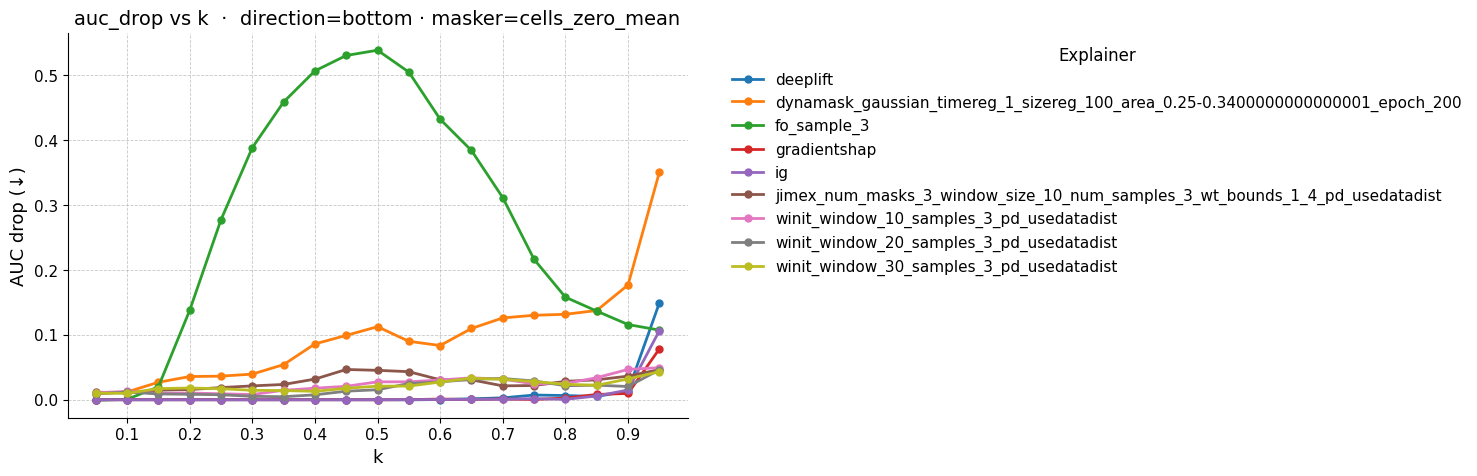

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_bottom__masker_cells_mean_mean.png


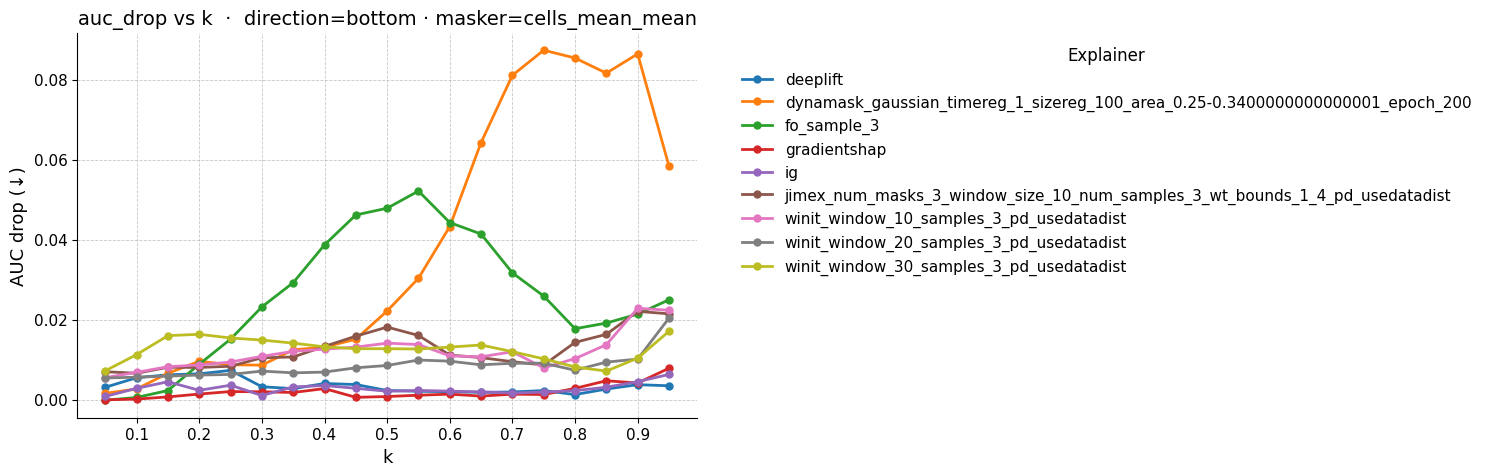

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/auc_drop_vs_k__direction_bottom__masker_nan.png


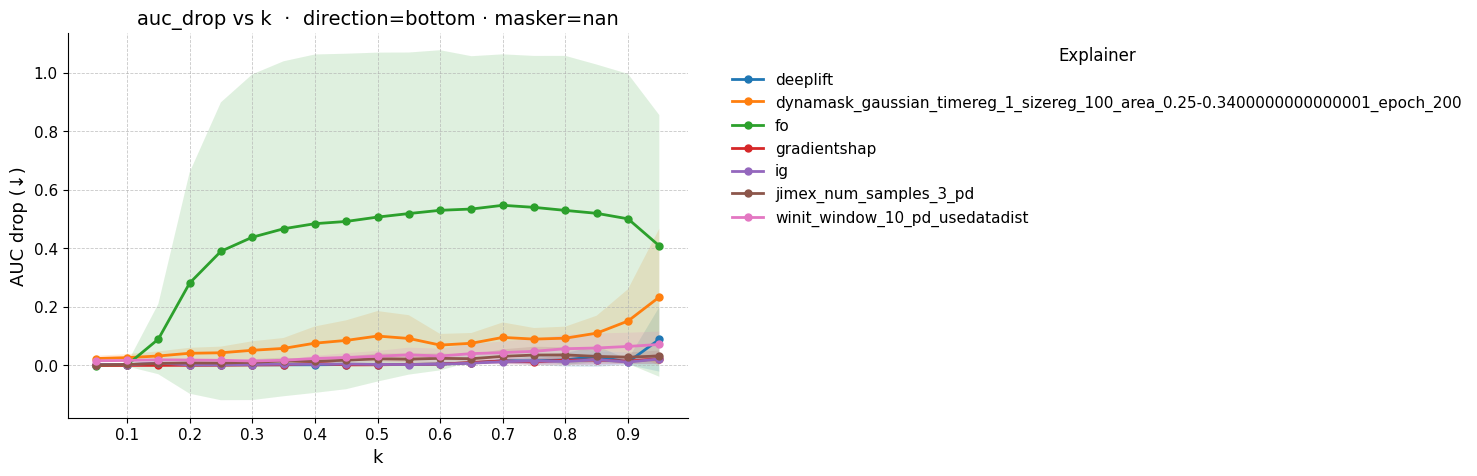

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_bottom__masker_cells_zero_mean.png


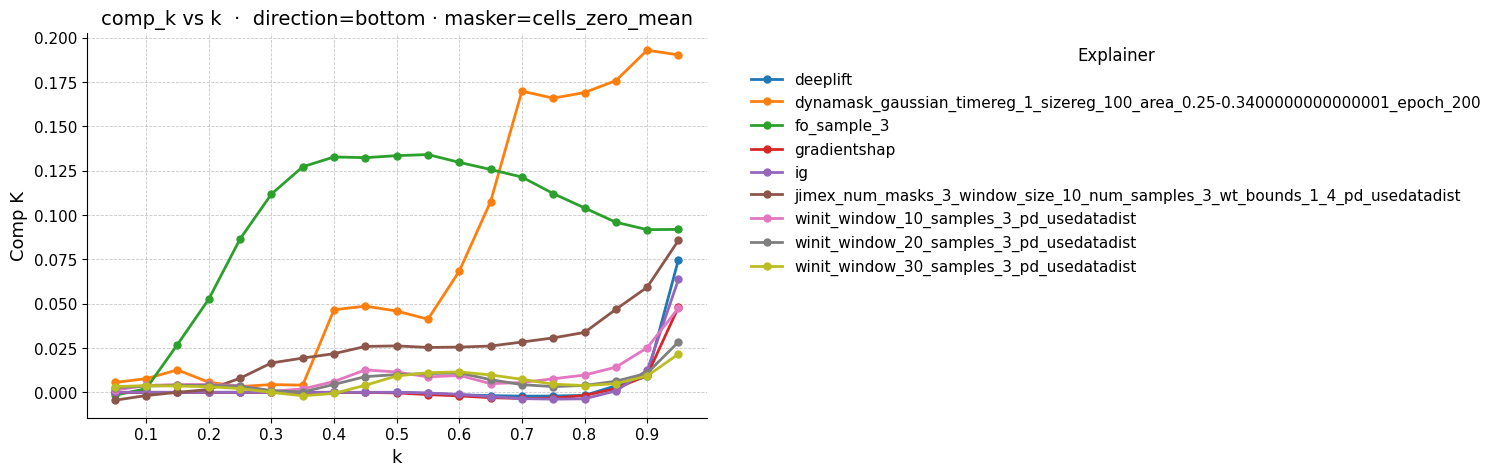

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_bottom__masker_cells_mean_mean.png


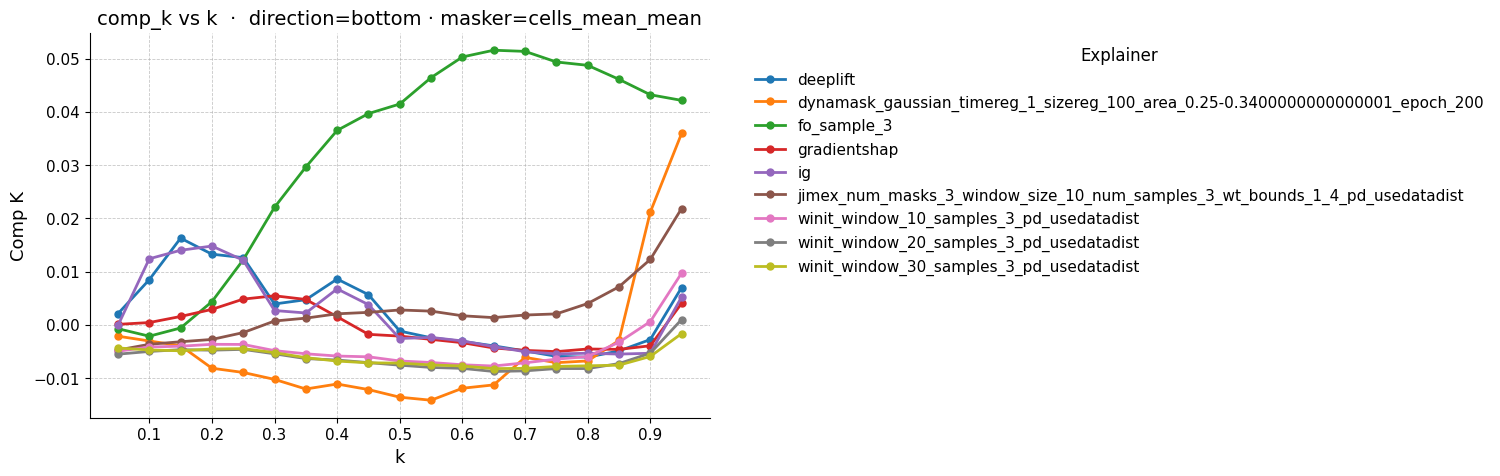

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/comp_k_vs_k__direction_bottom__masker_nan.png


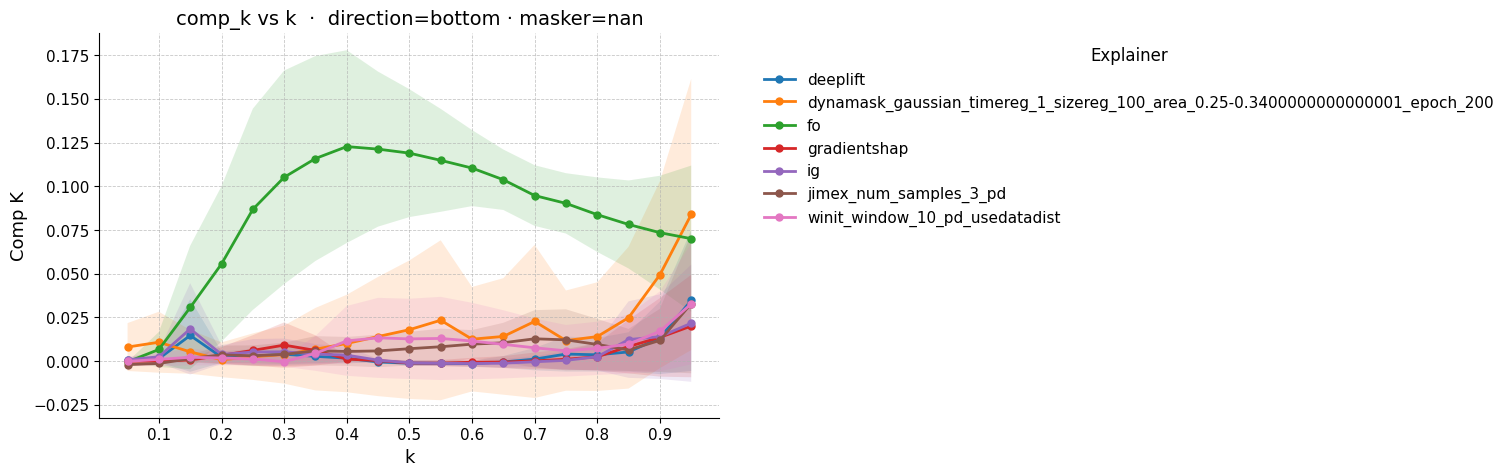

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_bottom__masker_cells_zero_mean.png


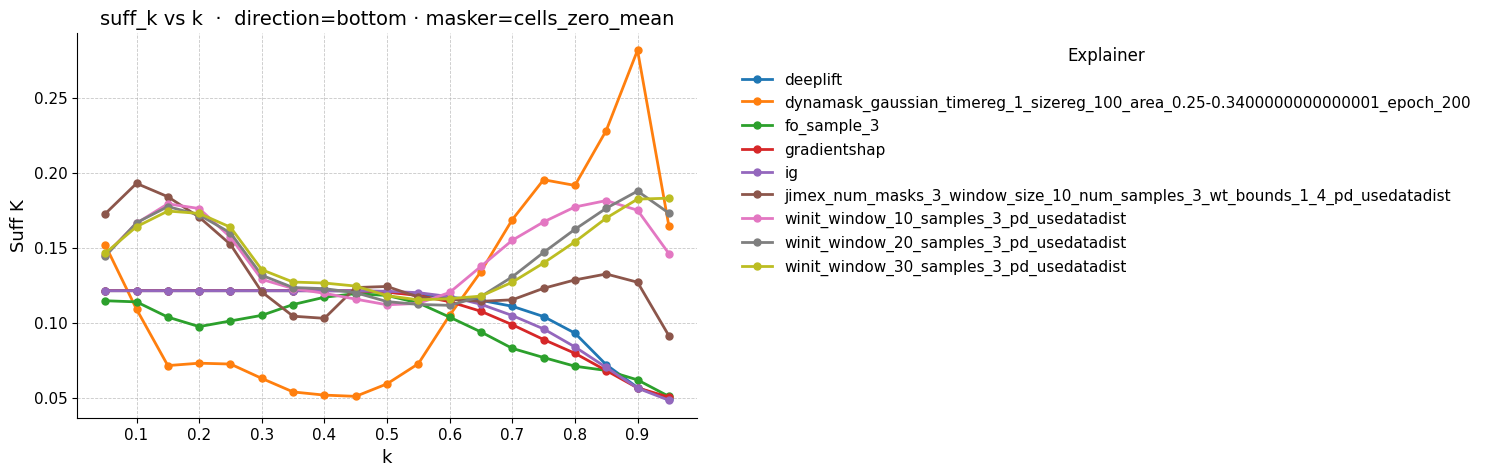

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_bottom__masker_cells_mean_mean.png


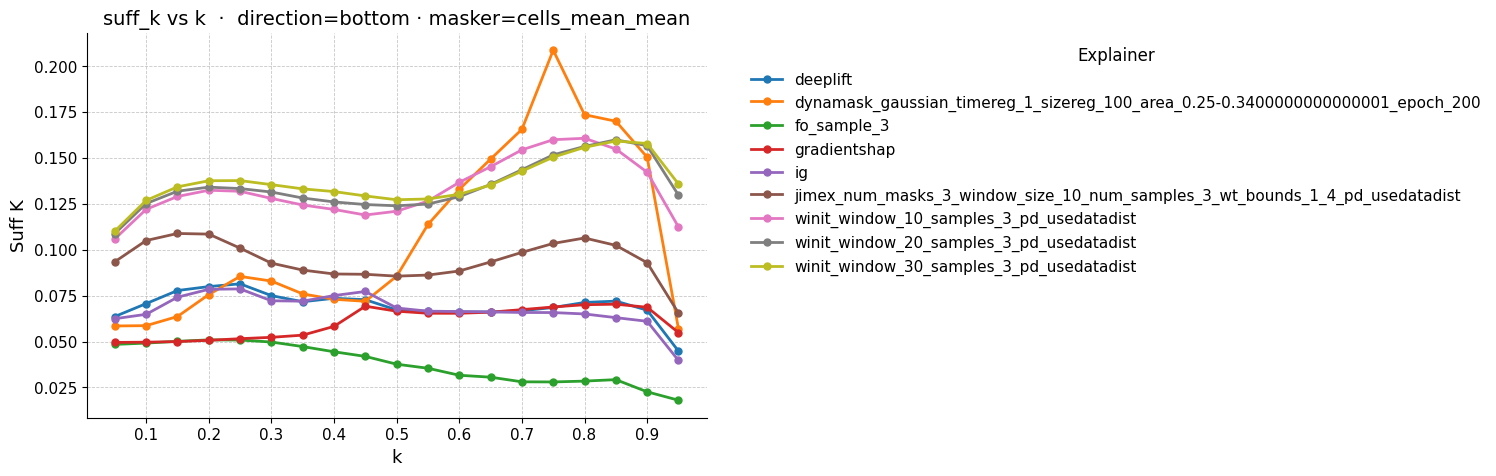

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/suff_k_vs_k__direction_bottom__masker_nan.png


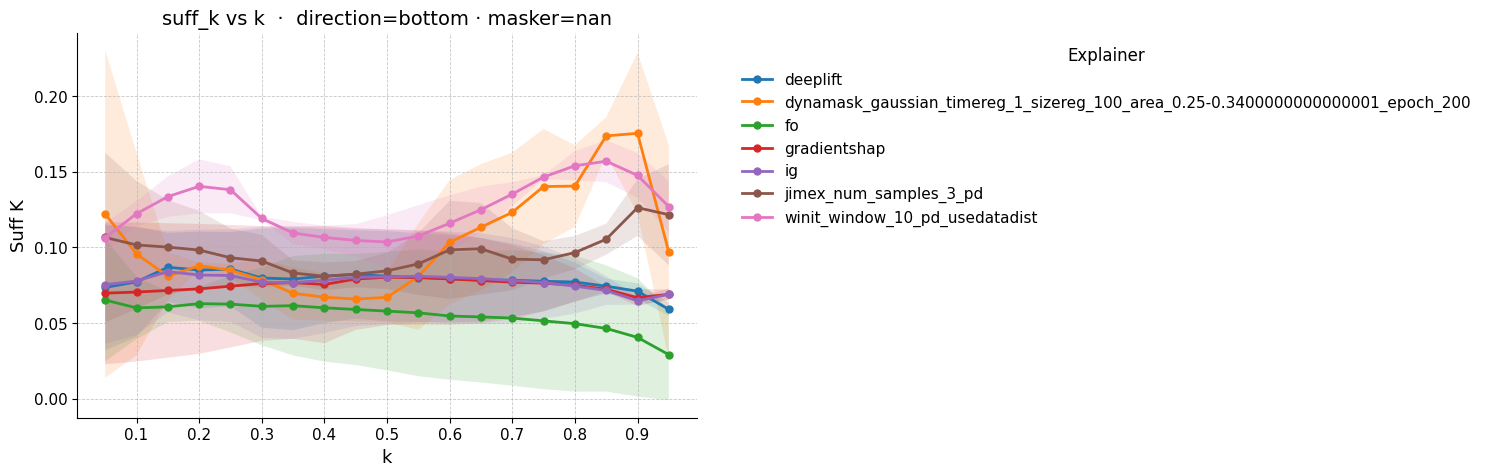

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_bottom__masker_cells_zero_mean.png


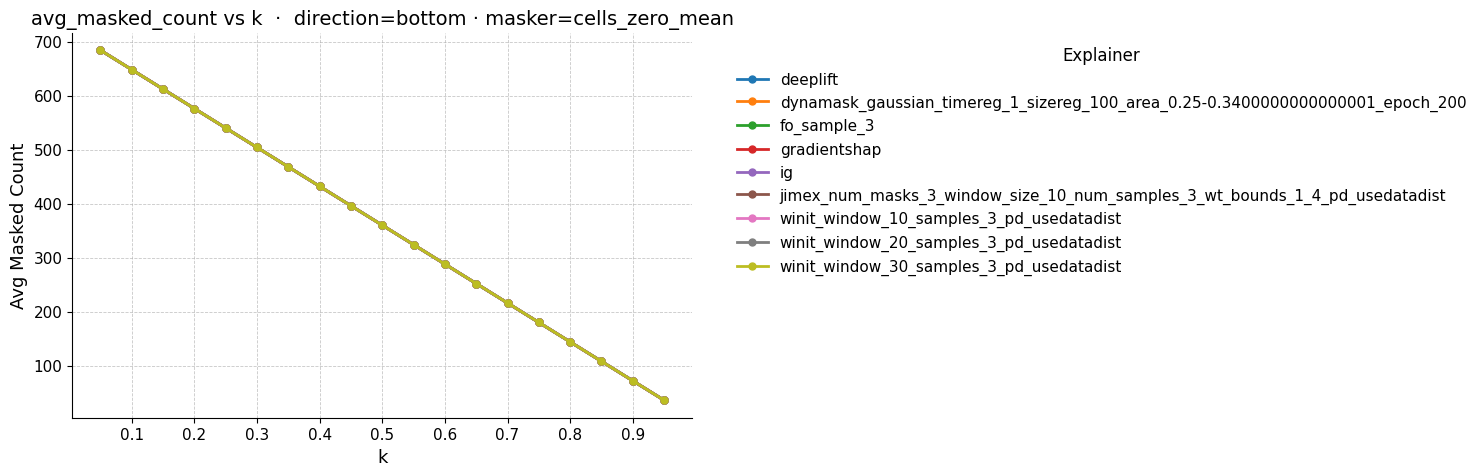

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_bottom__masker_cells_mean_mean.png


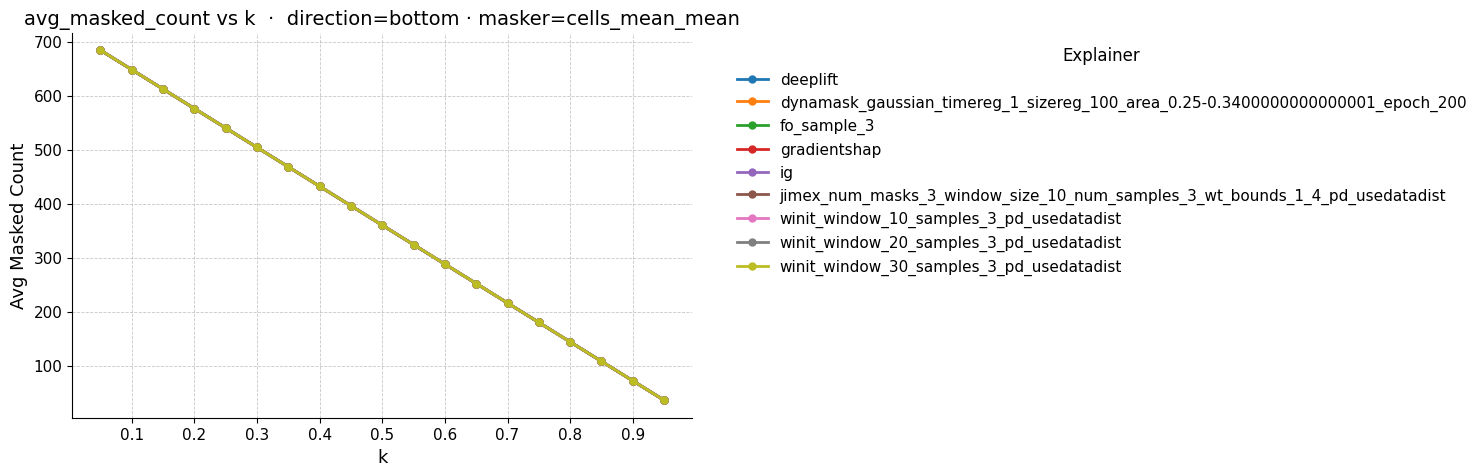

/tmp/ipykernel_1368536/4036940181.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


[SAVED] /home/users/nus/e1333861/graph-winit/plots/gru1layer/boiler/avg_masked_count_vs_k__direction_bottom__masker_nan.png


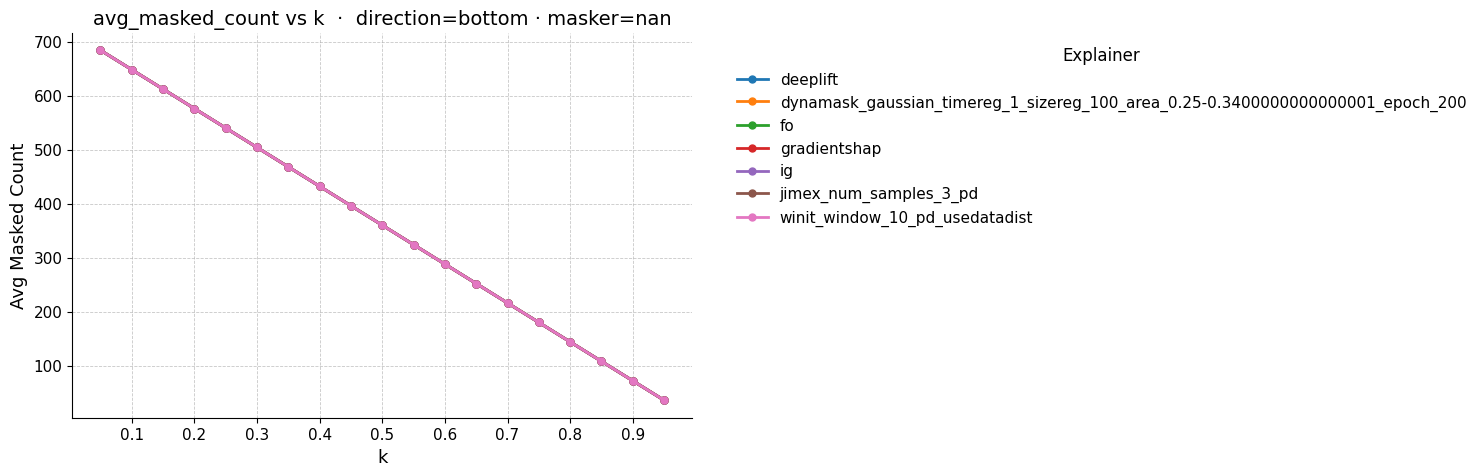

In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# ---------- CONFIG ----------
DATASET_NAME = "boiler"
DATA_DIR = "/home/users/nus/e1333861/graph-winit/output/gru1layer/" + DATASET_NAME
PATTERN = os.path.join(DATA_DIR, "results*.csv")  # matches results.csv, results (1).csv, results(2).csv, etc
OUT_DIR = os.path.join("/home/users/nus/e1333861/graph-winit/", "plots", "gru1layer", DATASET_NAME)
METRICS = ["auc_drop", "comp_k", "suff_k", "avg_masked_count"]
DIRECTION_ORDER = ["top", "bottom"]  # will auto-fallback to whatever exists
# ----------------------------

os.makedirs(OUT_DIR, exist_ok=True)

# Read & merge
paths = sorted(glob.glob(PATTERN))
if not paths:
    raise FileNotFoundError(f"No files found with pattern: {PATTERN}")

dfs = []
for p in paths:
    try:
        df_i = pd.read_csv(p)
        df_i["__source"] = os.path.basename(p)
        dfs.append(df_i)
    except Exception as e:
        print(f"[WARN] Failed to read {p}: {e}")

if not dfs:
    raise RuntimeError("No readable CSVs found.")

df = pd.concat(dfs, ignore_index=True)

# Basic sanity: required columns (masker_name optional—handled below)
required_cols = {"explainer", "k", "direction"} | set(METRICS)
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns in merged data: {missing}")

# Clean types
df["k"] = pd.to_numeric(df["k"], errors="coerce")
for m in METRICS:
    df[m] = pd.to_numeric(df[m], errors="coerce")
df = df.dropna(subset=["k", "explainer", "direction"])

# Shorten explainer labels: before first underscore #TODO
df["explainer_short"] = df["explainer"].astype(str)#.apply(lambda s: s.split("_")[0])

# --- NEW: detect masker_name values (if present) ---
HAS_MASKER = "masker_name" in df.columns
if HAS_MASKER:
    masker_values = list(pd.unique(df["masker_name"].astype(str)))
else:
    masker_values = [None]  # single pass fallback

# ICML-ish matplotlib style (no seaborn)
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Directions to plot (keep the specified order if present)
directions_in_data = [d for d in DIRECTION_ORDER if d in df["direction"].unique()]
for d in df["direction"].unique():
    if d not in directions_in_data:
        directions_in_data.append(d)

def plot_one(metric: str, direction: str, masker_name: str ):
    # Filter by direction (+ masker if available)
    sub = df[df["direction"] == direction].copy()
    if masker_name is not None:
        sub = sub[sub["masker_name"].astype(str) == str(masker_name)]
    if sub.empty:
        tag = f"direction={direction}" + ("" if masker_name is None else f", masker_name={masker_name}")
        print(f"[INFO] Skipping: {tag} has no rows.")
        return

    # Aggregate across repeats: mean ± std for each (explainer_short, k)
    agg = (sub.groupby(["explainer_short", "k"], as_index=False)[metric]
              .agg(mean="mean", std="std", n="count")
              .sort_values(["explainer_short", "k"]))

    # Create plot
    fig, ax = plt.subplots()

    # Plot each explainer curve
    for explainer, g in agg.groupby("explainer_short"):
        x = g["k"].to_numpy()
        y = g["mean"].to_numpy()
        s = g["std"].to_numpy()

        # Sort by k just in case
        order = np.argsort(x)
        x, y, s = x[order], y[order], s[order]

        ax.plot(x, y, marker="o", linewidth=2, markersize=5, label=str(explainer))
        # Shaded std if there are multiple runs
        if np.isfinite(s).any() and (g["n"] > 1).any():
            ax.fill_between(x, y - s, y + s, alpha=0.15)

    # Labels & legend
    ax.set_xlabel("k")
    pretty_y = {"auc_drop": "AUC drop (↓)",
                "comp_k": "Comp K",
                "suff_k": "Suff K",
                "avg_masked_count": "Avg Masked Count"}.get(metric, metric)
    ax.set_ylabel(pretty_y)

    # Nice integer ticks for k
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    # Place legend outside
    ax.legend(title="Explainer", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")

    # Title + filename pieces
    mask_tag = "" if masker_name is None else f" · masker={masker_name}"
    ax.set_title(f"{metric} vs k  ·  direction={direction}{mask_tag}")

    fig.tight_layout()

    # Save + show
    mask_slug = "nomasker" if masker_name is None else f"masker_{str(masker_name).replace(' ', '_')}"
    out_name = f"{metric}_vs_k__direction_{direction}__{mask_slug}.png"
    out_path = os.path.join(OUT_DIR, out_name)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"[SAVED] {out_path}")
    plt.show()
    plt.close(fig)

# Generate all plots:
# If masker_name exists, this will naturally produce 2× the plots (one set per masker).
for direction in directions_in_data:
    for metric in METRICS:
        for masker_name in masker_values:
            plot_one(metric, direction, masker_name)


### AUC Drop performance on MIMIC-III mortality using different metrics in WinIT for STD masking. <a class="anchor" id="bullet6"></a>$\quad$ [TOP](#bullet0) 

### Counts of masked observations for IG, FIT, Dynamask and WinIT at each time step in the MIMIC-III _K_=50 performance drop experiment. <a class="anchor" id="bullet7"></a>$\quad$ [TOP](#bullet0) 
Note that the bar charts are overlapping, instead of stacking.

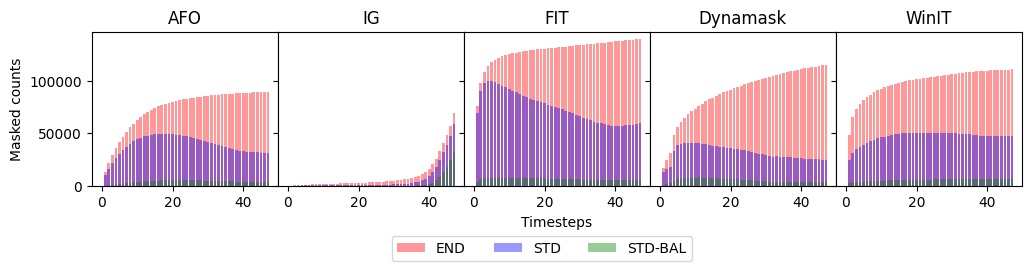

In [10]:
drops = ["top50_end_mean", "top50_std_mean", "bal50_std_mean"]
drop_names = ["END", "STD", "STD-BAL"]
explainers = ["afo", "ig", "fit", "dynamask_fadema_deletion_timereg_0_sizereg_10000_area_0.05_epoch_200",
              "winit_window_10_pd"]
explainer_names = ["AFO", "IG", "FIT", "Dynamask", "WinIT"]
colors = ["red", "blue", "green"]

dic = {}
for drop, explainer in itertools.product(drops, explainers):
    li = [
        np.load(f"../plots/gru1layer/mimic/array/{explainer}_{drop}_all_mask_cv_{cv}.npy")
        for cv in range(5)
    ]
    dic[f"{drop}_{explainer}"] = np.mean(np.stack(li), axis=0)

plt.close()
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, len(explainers), hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for j, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names)):
    for i, (drop, drop_name, color) in enumerate(zip(drops, drop_names, colors)):
        arr = dic[f"{drop}_{explainer}"]
        axs[j].bar(np.arange(len(arr)), arr, alpha=0.4, color=colors[i], label=drop_name)
    axs[j].set_title(explainer_name)
    
axs[0].set_ylabel("Masked counts")
axs[2].set_xlabel("Timesteps")
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.3))
plt.show()

### Performance on MIMIC for different window sizes <a class="anchor" id="bullet8"></a>$\quad$ [TOP](#bullet0) 

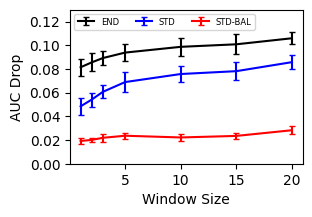

In [11]:
drops = ["top50_end_mean", "top50_std_mean", "bal50_std_mean"]
drop_names = ["END", "STD", "STD-BAL"]
colors = ["black", "blue", "red"]
windows = [1,2,3,5,10,15,20]
explainers = [f"winit_window_{w}_pd" for w in windows]
dh = (df
      .drop(["cv", "avg_masked_count", "avg_pred_diff"], axis=1)
      .groupby(["drop", "explainer"])
      .agg(["mean", "std"])
     )

plt.close()
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_ylabel("AUC Drop")
ax.set_xlabel("Window Size")

for drop, drop_name, color in zip(drops, drop_names, colors):
    dj = dh.loc[drop].loc[explainers]["auc_drop"]
    ax.errorbar(windows, dj["mean"], yerr=dj["std"], capsize=2, color=color, label=drop_name)
ax.legend(loc="upper left", ncol=3, fontsize=6)
ax.set_ylim(0, 0.13)
ax.set_yticks(np.arange(0, 0.13, 0.02))
plt.show()

### Precision-Recall Curve for Dynamask <a class="anchor" id="bullet10"></a>$\quad$ [TOP](#bullet0) 

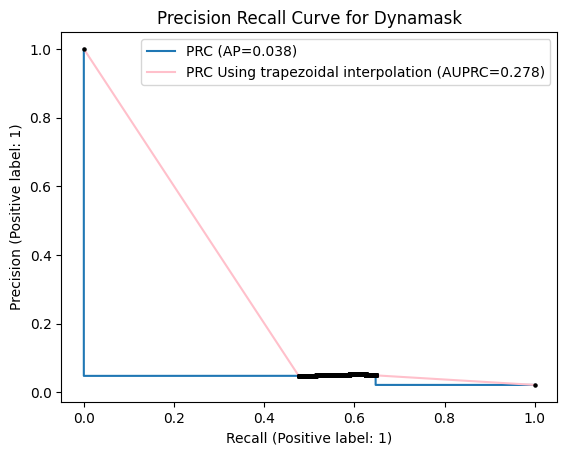

In [13]:
cv = 0
files = [f for f in os.listdir("../output/gru1layer/simulated_state/") if f.startswith("dynamask") and f.endswith(f"{cv}.pkl")]
with open("../output/gru1layer/simulated_state/" + files[0], "rb") as f:
    imp = pkl.load(f)
    
with open('../data/simulated_state_data/state_dataset_importance_test.pkl', 'rb') as f:
    gt = pkl.load(f)

p, r, t = precision_recall_curve(gt.reshape(-1), imp.reshape(-1))
    
plt.close()
display = PrecisionRecallDisplay.from_predictions(
    gt.reshape(-1), imp.reshape(-1)
)
_ = display.ax_.set_title("Precision Recall Curve for Dynamask")
display.ax_.plot(r, p, color="pink", label="PRC Using trapezoidal interpolation (AUPRC=0.278)")
h, l = display.ax_.get_legend_handles_labels()
display.ax_.scatter(r, p, color="black", s=5, zorder=100)
l[0] = "PRC (AP=0.038)"
display.ax_.legend(h, l)
plt.show()

### AUC Drop, Mean Prediction Changes and number of masked observations for STD-BAL, STD and END masking method for different explainability methods on _K_=50 <a class="anchor" id="bullet11"></a>$\quad$ [TOP](#bullet0) 

In [14]:
def show_masking_barcharts(model_architecture):
    df = pd.read_csv(f"../output/{model_architecture}/mimic/results.csv")
    df["explainer"] = df["explainer"].apply(simplify_explainer_str)
    df = df.rename(columns={"level_0": "drop"})

    explainers = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", "dynamask", "winit_window_10_pd"]
    explainer_names = ["Deep LIFT", "GradSHAP", "IG", "FO", "AFO", "FIT", "Dynamask", "WinIT"]
    graphs = ["auc_drop", "avg_pred_diff", "avg_masked_count"]
    graph_names = ["AUC Drop", "Pred. Change", "Masked Count"]

    drops = ["STD-BAL", "STD", "END"]
    num_explainers = len(explainers)
    colors = ["pink", "pink", "pink", "greenyellow", "greenyellow", "blue", "orange", "mediumpurple"]
    hatches = [None, "///", "++", None, "///", None, None, None]
    ind = np.arange(3)
    width = 0.8
    bar_width = width / num_explainers

    dh = df.drop("cv", axis=1).groupby(by=["explainer", "drop"]).agg("mean").reset_index()
    dh = dh[dh["drop"].apply(lambda x : not x.startswith("global"))]
    dh["drop"] = dh["drop"].apply(lambda x: "STD-BAL" if x.startswith("bal") else x.split("_")[1].upper())

    plt.close()
    fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
    for j, (graph, graph_name) in enumerate(zip(graphs, graph_names)):
        for i, (explainer, explainer_name, color, hatch) in enumerate(
            zip(explainers, explainer_names, colors, hatches)):
            data = dh[dh["explainer"] == explainer].set_index("drop").loc[drops, graph]
            data = np.maximum(data, 0)
            ax[j].barh(ind + i * bar_width, data, bar_width, color=color, 
                       label=explainer_name, hatch=hatch, edgecolor="black")
        ax[j].set_yticks(ind + bar_width * (num_explainers - 1) / 2)
        ax[j].set_yticklabels(drops, rotation=90, va="center")
        ax[j].set_title(graph_name)
        handles, labels = ax[j].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncols=4)
    plt.show()

### Base model = 1-Layer GRU <a class="anchor" id="bullet12"></a>$\quad$ [TOP](#bullet0) 

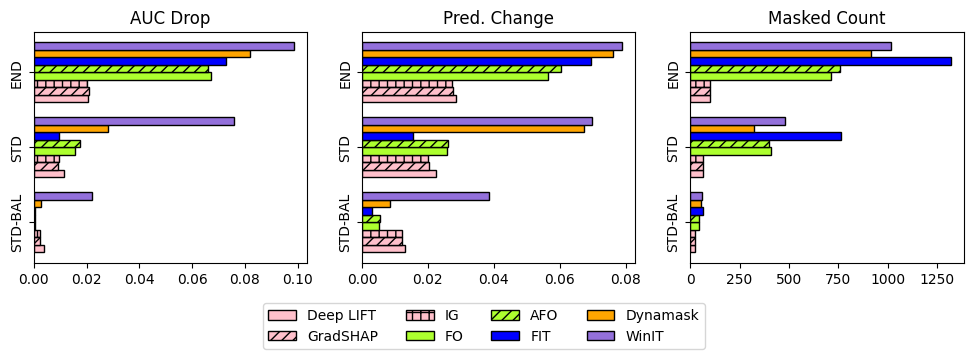

In [15]:
show_masking_barcharts("gru1layer")